P8.1 Prepare a code which draw for given network plot of the relation C(k). [1P]

In [55]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_clustering_vs_degree(G):
    # Calculate degree and clustering coefficient
    degrees = dict(G.degree())
    clustering = nx.clustering(G)

    # Group clustering coefficients by degree
    degree_clustering = {}
    for node, degree in degrees.items():
        if degree not in degree_clustering:
            degree_clustering[degree] = []
        degree_clustering[degree].append(clustering[node])

    # Compute average clustering coefficient for each degree
    avg_clustering_per_degree = {
        degree: np.mean(clustering_list)
        for degree, clustering_list in degree_clustering.items()
    }

    # Sort by degree for better visualization
    sorted_degrees = sorted(avg_clustering_per_degree.keys())
    sorted_avg_clustering = [avg_clustering_per_degree[d] for d in sorted_degrees]

    # Plot the network
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, with_labels=False, edge_color="gray")
    plt.title("Network Plot")

    # Plot C(k) vs degree k
    plt.subplot(1, 2, 2)
    plt.plot(sorted_degrees, sorted_avg_clustering, marker="o", linestyle="--", color="blue")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Degree (k) [log scale]")
    plt.ylabel("Clustering Coefficient C(k) [log scale]")
    plt.title("Clustering Coefficient vs Degree")

    plt.tight_layout()
    plt.show()




P 8.2

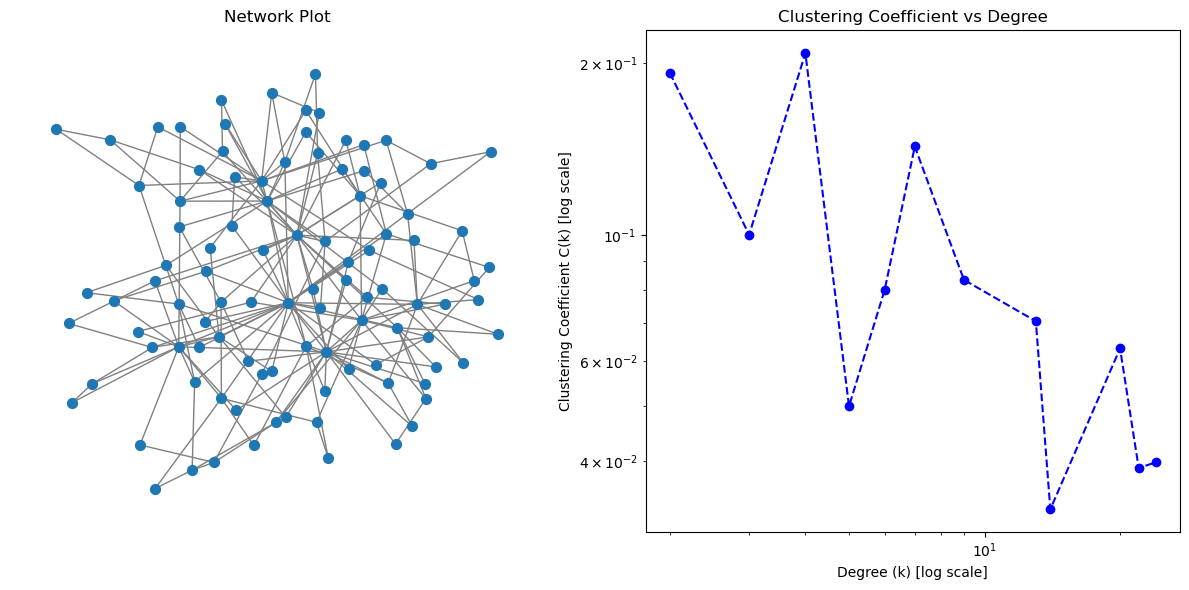

In [56]:
G = nx.barabasi_albert_graph(100, 2)
plot_clustering_vs_degree(G)

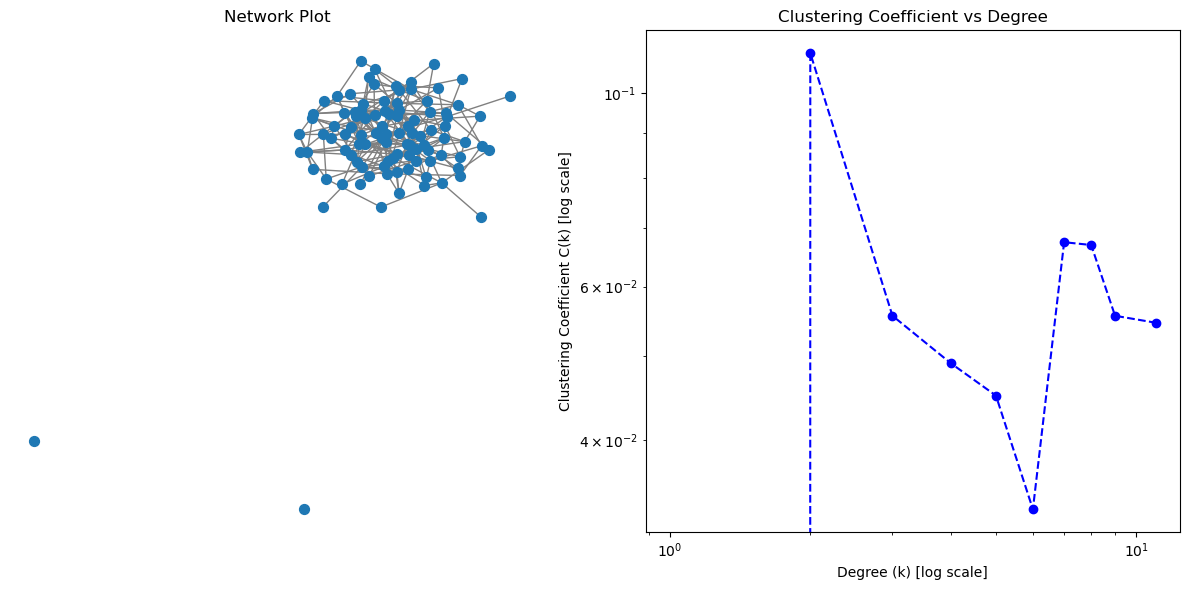

In [57]:
G = nx.erdos_renyi_graph(100, 0.05)
plot_clustering_vs_degree(G)

In [58]:
import networkx as nx

def load_citation_network(filename, top_n=None):
    G = nx.DiGraph()  # Use a directed graph for the citation network
    with open(filename, 'r') as file:
        if top_n is not None:
            file = [next(file) for _ in range(top_n)]
        for line in file:
            # Split the line into source and target
            source, target = str(line).strip().split(' ')
            G.add_edge(source, target)  # Add the edge to the graph
    return G

# Load the citation graph from the file
citation_network = load_citation_network('cit-DBLP.edges', 1400)

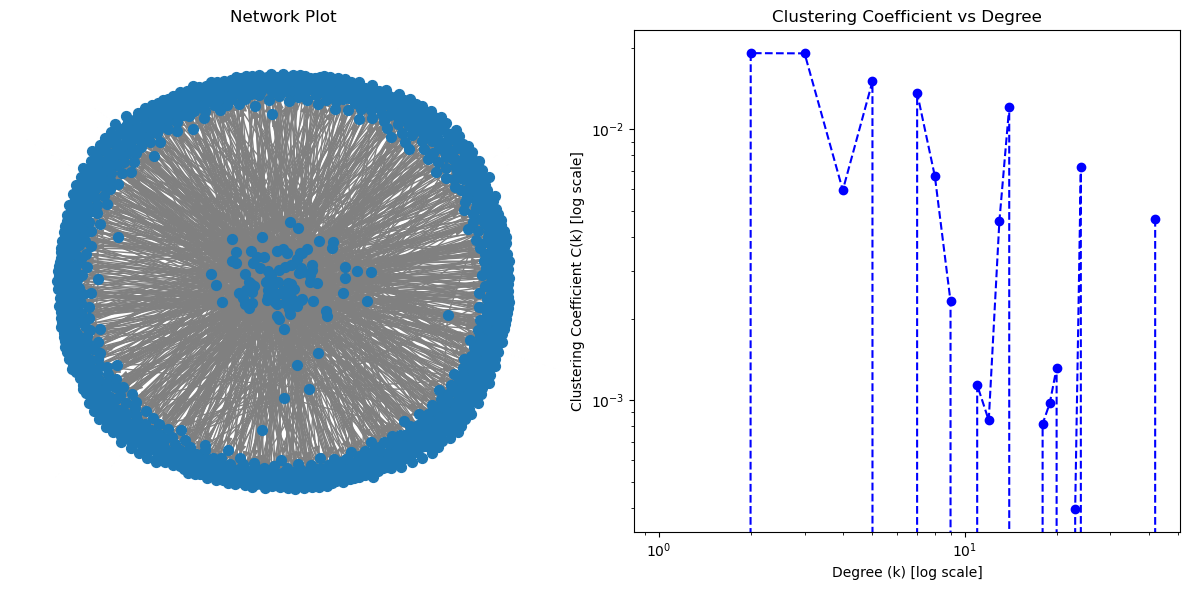

In [59]:
plot_clustering_vs_degree(citation_network)

P8.3 

In [60]:
import os
from datetime import timedelta

import networkx as nx
import pandas as pd


def parse_gtfs(path, service_id=None, first_trip_only=False):
    """
    Creates a directed graph from GTFS data where nodes represent stops and edges represent connections.

    The function reads GTFS files (stops.txt, routes.txt, trips.txt, stop_times.txt) and creates a networkx
    DiGraph where:
    - Nodes represent stops and are identified by their stop_id with attributes:
        * lines (set): routes serving the stop
        * types (set): transport types serving the stop (e.g., 'bus', 'tram', 'rail')
        * lat (float): latitude coordinate of the stop
        * lng (float): longitude coordinate of the stop
        * name (str): name of the stop
        * code (str): stop code (if available, else None)
    - Edges represent connections between consecutive stops on routes with attributes:
        * lines (set): routes using the connection
        * types (set): transport types using the connection
        * distance (float): distance between stops in kilometers
        * vehicles (list): list of dictionaries containing:
            - departure (timedelta): departure time from source stop
            - arrival (timedelta): arrival time at target stop (minus 1 second)
            - line (str): route identifier

    Args:
        path (str): Path to directory containing GTFS files
        service_id (str, optional): Filter trips by service_id. If None, all trips are included.
        first_trip_only (bool): If True, only use the first trip for each route and direction.
            This means up to two trips per route: one for direction_id=0 and one for direction_id=1.
            Default: False

    Returns:
        tuple[nx.DiGraph, dict]: A tuple containing:
            - nx.DiGraph: Directed graph representing the transport network
            - dict: Mapping of route_id to transport type (e.g., 'bus', 'tram', etc.)
    """
    G = nx.DiGraph()

    stops_df = pd.read_csv(os.path.join(path, "stops.txt"))
    routes_df = pd.read_csv(os.path.join(path, "routes.txt"))
    trips_df = pd.read_csv(os.path.join(path, "trips.txt"))
    times_df = pd.read_csv(os.path.join(path, "stop_times.txt"))

    type_mapping = {
        0: "tram",
        1: "subway",
        2: "rail",
        3: "bus",
        4: "ferry",
        5: "cable_tram",
        6: "aerial_lift",
        7: "funicular",
    }
    route_types = {
        route_id: type_mapping.get(route_type, "unknown")
        for route_id, route_type in zip(routes_df.route_id, routes_df.route_type)
    }

    print("Adding nodes...")
    nodes_data = [
        (
            stop.stop_id,
            {
                "lat": float(stop.stop_lat),
                "lng": float(stop.stop_lon),
                "lines": set(),
                "types": set(),
                "name": stop.stop_name,
                "code": (
                    stop.stop_code
                    if "stop_code" in stop and pd.notna(stop.stop_code)
                    else None
                ),
            },
        )
        for _, stop in stops_df.iterrows()
    ]
    G.add_nodes_from(nodes_data)

    # Filter trips
    if service_id is not None:
        trips_df = trips_df[trips_df.service_id == service_id]
    if first_trip_only:
        trips_df = trips_df.groupby(["route_id", "direction_id"]).first().reset_index()

    # Add route_id to stop times data
    times_df = pd.merge(
        times_df,
        trips_df[["trip_id", "route_id"]],
        on="trip_id",
        how="inner",
    )

    edges_data = {}
    all_trips_count = len(times_df.trip_id.unique())
    processed_trips_count = 0

    for trip_id, group in times_df.groupby("trip_id"):
        route_id = group.iloc[0].route_id
        route_type = route_types[route_id]

        processed_trips_count += 1
        print(
            f"Processing trip {trip_id}, route_id {route_id}, route_type {route_type} ({processed_trips_count}/{all_trips_count})"
        )

        stops = group.sort_values("stop_sequence")

        # Update node attributes
        for stop_id in stops.stop_id:
            G.nodes[stop_id]["lines"].add(route_id)
            G.nodes[stop_id]["types"].add(route_type)

        # Create edges
        for i in range(len(stops) - 1):
            row1, row2 = stops.iloc[i], stops.iloc[i + 1]
            stop1, stop2 = row1.stop_id, row2.stop_id

            dist = float(row2.shape_dist_traveled) - float(row1.shape_dist_traveled)
            vehicle_info = {
                "departure": parse_time(row1.departure_time),
                "arrival": parse_time(row2.arrival_time) - timedelta(seconds=1),
                "line": route_id,
            }

            if (stop1, stop2) in edges_data:
                edges_data[(stop1, stop2)]["lines"].add(route_id)
                edges_data[(stop1, stop2)]["types"].add(route_type)
                edges_data[(stop1, stop2)]["vehicles"].append(vehicle_info)
            else:
                edges_data[(stop1, stop2)] = {
                    "lines": {route_id},
                    "types": {route_type},
                    "distance": dist,
                    "vehicles": [vehicle_info],
                }

    print("Adding edges...")
    edges = [(stop1, stop2, data) for (stop1, stop2), data in edges_data.items()]
    G.add_edges_from(edges)

    return G, route_types


def parse_time(time_str: str) -> timedelta:
    h, m, s = map(int, time_str.split(":"))
    return timedelta(hours=h, minutes=m, seconds=s)


In [ ]:
G, route_types = parse_gtfs("gtfs", service_id="3_2", first_trip_only=True)


Adding nodes...
Processing trip 3_2_1009049, route_id 3_738, route_type bus (1/635)
Processing trip 3_2_1009050, route_id 3_738, route_type bus (2/635)
Processing trip 3_2_1085745, route_id 3_160, route_type bus (3/635)
Processing trip 3_2_1085746, route_id 3_160, route_type bus (4/635)
Processing trip 3_2_1085749, route_id 3_527, route_type bus (5/635)
Processing trip 3_2_1085750, route_id 3_527, route_type bus (6/635)
Processing trip 3_2_1086998, route_id 3_349, route_type bus (7/635)
Processing trip 3_2_1086999, route_id 3_349, route_type bus (8/635)
Processing trip 3_2_1108162, route_id 3_356, route_type bus (9/635)
Processing trip 3_2_1108163, route_id 3_356, route_type bus (10/635)
Processing trip 3_2_1140611, route_id 3_13, route_type tram (11/635)
Processing trip 3_2_1140612, route_id 3_13, route_type tram (12/635)
Processing trip 3_2_1155587, route_id 3_31, route_type tram (13/635)
Processing trip 3_2_1155588, route_id 3_31, route_type tram (14/635)
Processing trip 3_2_1177086

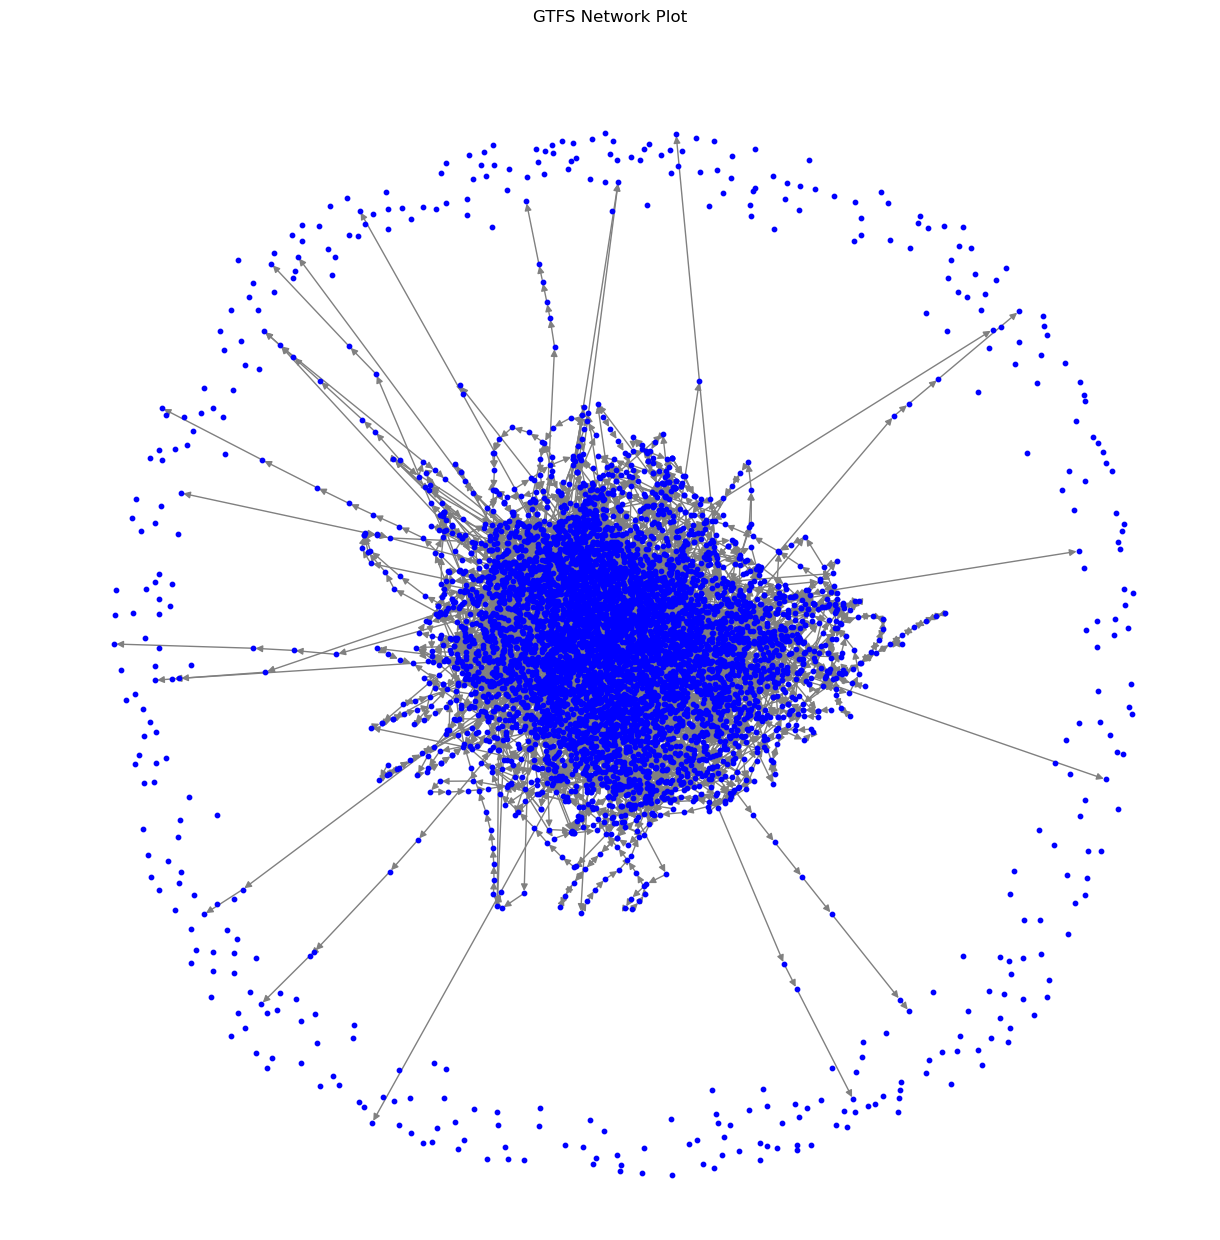

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=10, node_color="blue", edge_color="gray", with_labels=False)
plt.title("GTFS Network Plot")
plt.show()

In [17]:
def filter_graph_by_transport_type(G, transport_type):
    G_filtered = G.copy()
    nodes_to_remove = [node for node, data in G_filtered.nodes(data=True) if transport_type not in data['types']]
    G_filtered.remove_nodes_from(nodes_to_remove)
    return G_filtered

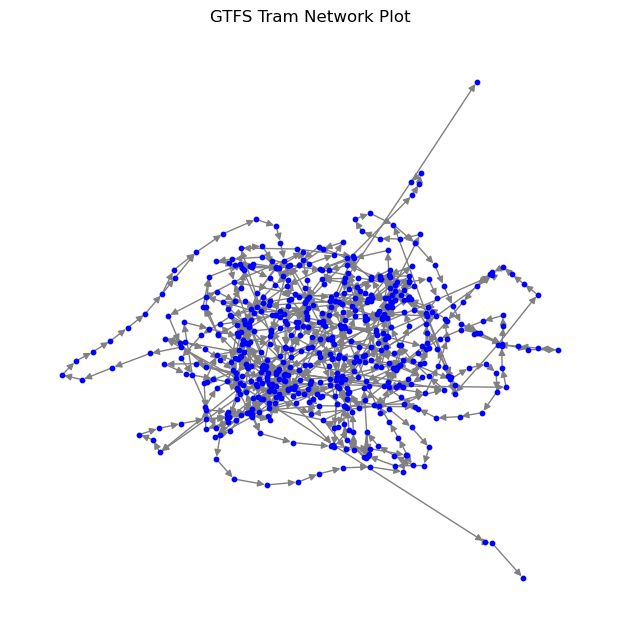

In [19]:
G_tram = filter_graph_by_transport_type(G, "tram")

plt.figure(figsize=(6, 6))
pos_tram = nx.spring_layout(G_tram, seed=42)
nx.draw(G_tram, pos_tram, node_size=10, node_color="blue", edge_color="gray", with_labels=False)
plt.title("GTFS Tram Network Plot")
plt.show()

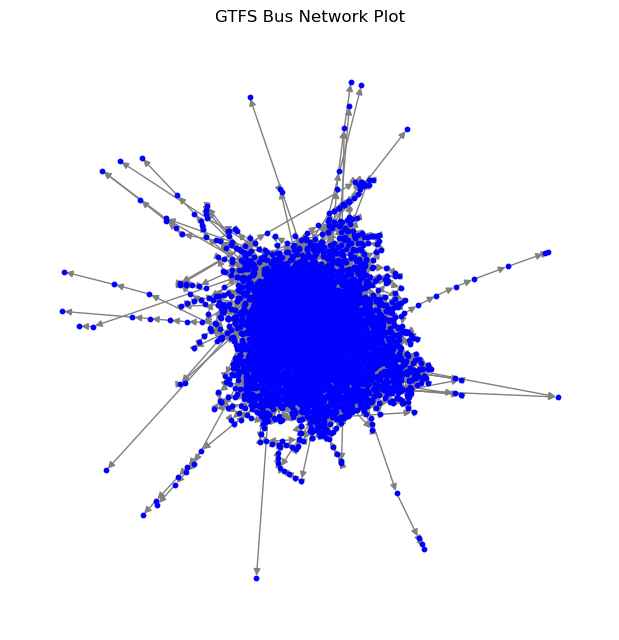

In [18]:
G_bus = filter_graph_by_transport_type(G, 'bus')

plt.figure(figsize=(6, 6))
pos_bus = nx.spring_layout(G_bus, seed=42)
nx.draw(G_bus, pos_bus, node_size=10, node_color="blue", edge_color="gray", with_labels=False)
plt.title("GTFS Bus Network Plot")
plt.show()

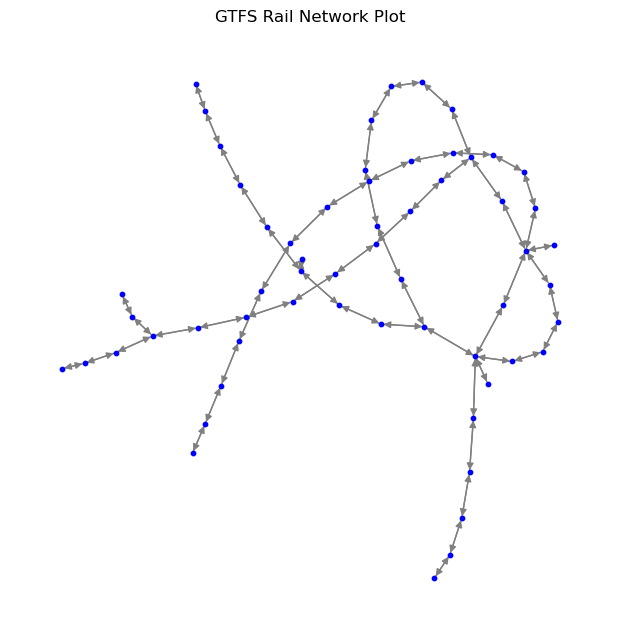

In [20]:
G_rail = filter_graph_by_transport_type(G, 'rail')

plt.figure(figsize=(6, 6))
pos_rail = nx.spring_layout(G_rail, seed=42)
nx.draw(G_rail, pos_rail, node_size=10, node_color="blue", edge_color="gray", with_labels=False)
plt.title("GTFS Rail Network Plot")
plt.show()

In [22]:
def calculate_network_characteristics(G):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    density = nx.density(G)
    avg_clustering_coefficient = nx.average_clustering(G)
    return {
        "Number of nodes": num_nodes,
        "Number of edges": num_edges,
        "Average degree": avg_degree,
        "Density": density,
        "Average clustering coefficient": avg_clustering_coefficient,
    }

# Calculate characteristics for the whole network
whole_network_characteristics = calculate_network_characteristics(G)
print("Whole Network Characteristics:")
print(whole_network_characteristics)

# Calculate characteristics for each layer
bus_network_characteristics = calculate_network_characteristics(G_bus)
print("\nBus Network Characteristics:")
print(bus_network_characteristics)

rail_network_characteristics = calculate_network_characteristics(G_rail)
print("\nRail Network Characteristics:")
print(rail_network_characteristics)

tram_network_characteristics = calculate_network_characteristics(G_tram)
print("\nTram Network Characteristics:")
print(tram_network_characteristics)

Whole Network Characteristics:
{'Number of nodes': 6979, 'Number of edges': 8427, 'Average degree': 2.4149591632038976, 'Density': 0.00017304092599626665, 'Average clustering coefficient': 0.008876666073255844}

Bus Network Characteristics:
{'Number of nodes': 5952, 'Number of edges': 7632, 'Average degree': 2.564516129032258, 'Density': 0.0002154693437264542, 'Average clustering coefficient': 0.010427909810470296}

Rail Network Characteristics:
{'Number of nodes': 59, 'Number of edges': 120, 'Average degree': 4.067796610169491, 'Density': 0.03506721215663355, 'Average clustering coefficient': 0.0}

Tram Network Characteristics:
{'Number of nodes': 587, 'Number of edges': 681, 'Average degree': 2.320272572402044, 'Density': 0.001979754754609253, 'Average clustering coefficient': 0.0}


In [24]:
G.nodes(data=True)

NodeDataView({3: {'lat': 52.20054, 'lng': 20.94777, 'lines': {'3_414'}, 'types': {'bus'}, 'name': 'Instalatorów', 'code': 3.0}, 9: {'lat': 52.18973589, 'lng': 20.95895588, 'lines': {'3_189', '3_401', '3_141'}, 'types': {'bus'}, 'name': 'Hynka', 'code': 5.0}, 12: {'lat': 52.19722463, 'lng': 20.96302732, 'lines': {'3_228', '3_414'}, 'types': {'bus'}, 'name': 'PKP Rakowiec', 'code': 6.0}, 13: {'lat': 52.19715413, 'lng': 20.96303153, 'lines': {'3_228', '3_414'}, 'types': {'bus'}, 'name': 'PKP Rakowiec', 'code': 5.0}, 14: {'lat': 52.19841315, 'lng': 20.95761317, 'lines': {'3_228', '3_414'}, 'types': {'bus'}, 'name': 'Instalatorów-KAM', 'code': 2.0}, 17: {'lat': 52.18558498, 'lng': 20.95500957, 'lines': {'3_317', '3_154'}, 'types': {'bus'}, 'name': 'Krakowiaków', 'code': 5.0}, 28: {'lat': 52.19666064, 'lng': 20.92996314, 'lines': {'3_187', '3_517', '3_717', '3_N35', '3_N01', '3_817'}, 'types': {'bus'}, 'name': 'Łopuszańska', 'code': 1.0}, 34: {'lat': 52.20019671, 'lng': 20.91452682, 'lines':

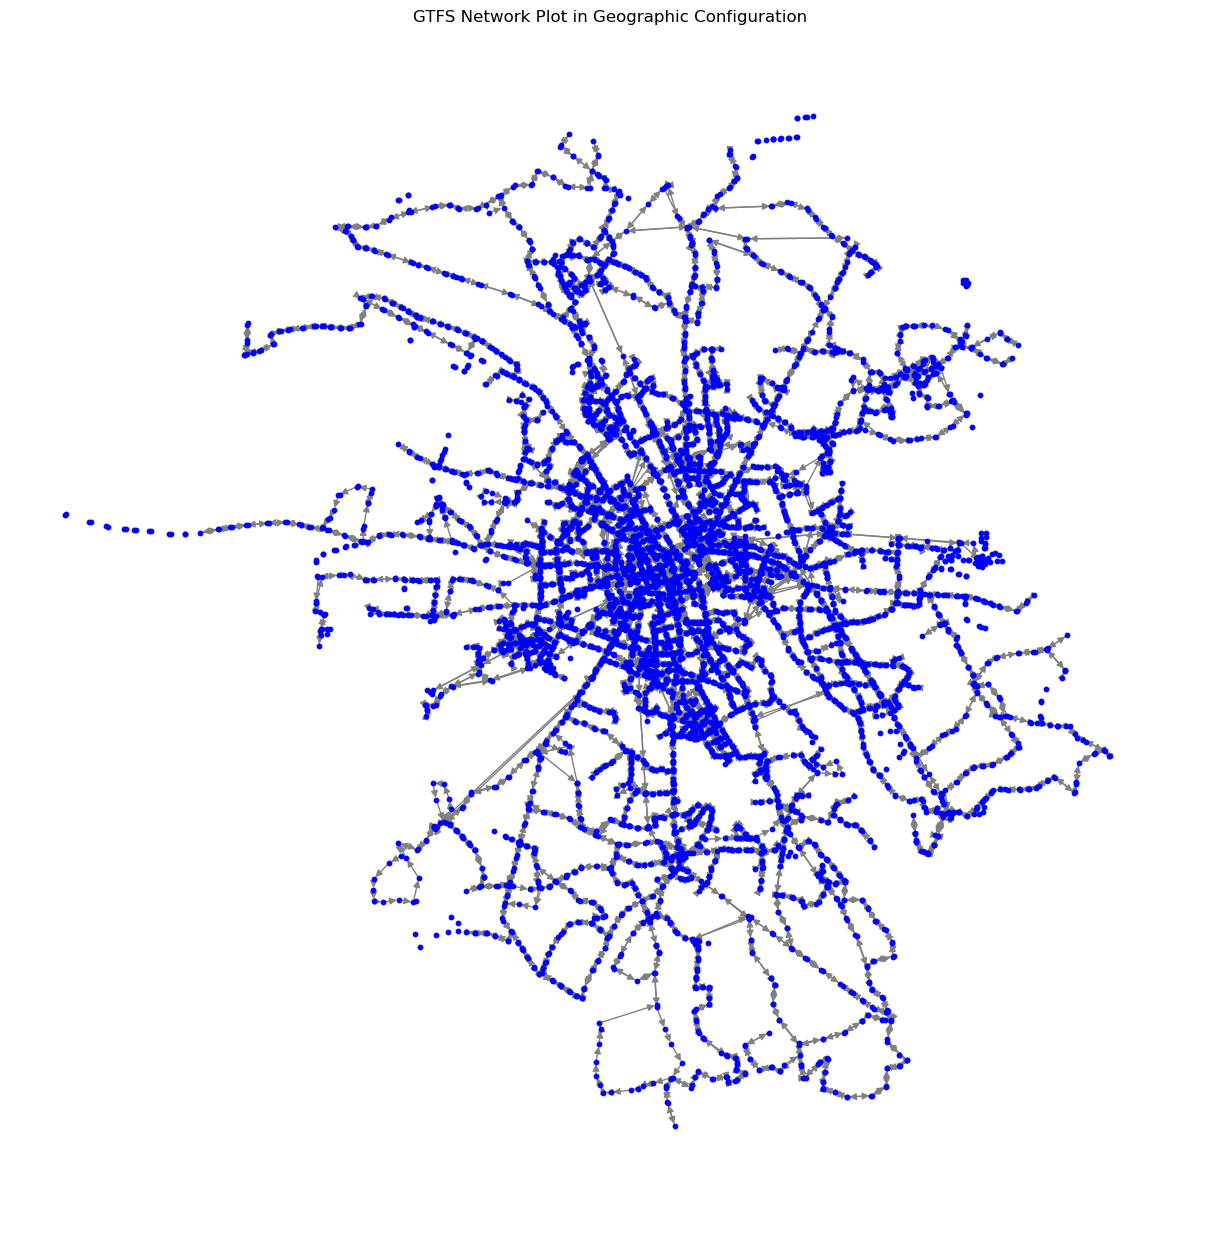

In [25]:
# Extract positions from the graph nodes
pos_geo = {node: (data['lng'], data['lat']) for node, data in G.nodes(data=True)}

# Draw the graph with geographic positions
plt.figure(figsize=(12, 12))
nx.draw(G, pos=pos_geo, node_size=10, node_color="blue", edge_color="gray", with_labels=False)
plt.title("GTFS Network Plot in Geographic Configuration")
plt.show()

In [26]:
import networkx as nx
from datetime import timedelta

def create_temporal_network(G):
    temporal_G = nx.MultiDiGraph()

    for u, v, data in G.edges(data=True):
        for vehicle in data['vehicles']:
            departure = vehicle['departure']
            arrival = vehicle['arrival']
            line = vehicle['line']
            temporal_G.add_edge(u, v, key=(departure, arrival), departure=departure, arrival=arrival, line=line)

    return temporal_G

# Create temporal networks for the whole network and each transport type
temporal_G = create_temporal_network(G)
temporal_G_bus = create_temporal_network(G_bus)
temporal_G_rail = create_temporal_network(G_rail)
temporal_G_tram = create_temporal_network(G_tram)

# Example: Print the edges of the temporal bus network
for u, v, key, data in temporal_G_bus.edges(data=True, keys=True):
    print(f"Edge from {u} to {v} active from {data['departure']} to {data['arrival']} on line {data['line']}")

Edge from 3 to 6308 active from 4:50:00 to 4:49:59 on line 3_414
Edge from 6308 to 6306 active from 4:50:00 to 4:50:59 on line 3_414
Edge from 6308 to 6306 active from 10:30:00 to 10:30:59 on line 3_228
Edge from 9 to 93 active from 7:44:00 to 7:46:59 on line 3_401
Edge from 9 to 6 active from 6:17:00 to 6:17:59 on line 3_189
Edge from 9 to 6 active from 11:06:00 to 11:07:59 on line 3_141
Edge from 93 to 99 active from 7:47:00 to 7:47:59 on line 3_401
Edge from 93 to 99 active from 8:17:00 to 8:17:59 on line 3_504
Edge from 93 to 99 active from 6:21:00 to 6:21:59 on line 3_189
Edge from 6 to 18 active from 6:18:00 to 6:19:59 on line 3_189
Edge from 6 to 18 active from 11:08:00 to 11:09:59 on line 3_141
Edge from 12 to 14 active from 6:45:00 to 6:45:59 on line 3_414
Edge from 12 to 14 active from 6:22:00 to 6:22:59 on line 3_228
Edge from 14 to 6307 active from 6:46:00 to 6:46:59 on line 3_414
Edge from 14 to 6307 active from 6:23:00 to 6:23:59 on line 3_228
Edge from 13 to 6577 active 

8.9 - with Patryk Prusak

add real examples

In [29]:
import polars as pl

stop_times_data = pl.read_csv(
    os.path.join("./gtfs", "stop_times.txt"), separator=",", has_header=True
)
trips_data = pl.read_csv(
    os.path.join("./gtfs", "trips.txt"), separator=",", has_header=True
)
routes_data = pl.read_csv(
    os.path.join("./gtfs", "routes.txt"), separator=",", has_header=True
)
 
stop_times_trips_merged = stop_times_data.join(trips_data, on="trip_id")
 
stop_times_trips_merged_routes_merged = stop_times_trips_merged.join(
    routes_data, on="route_id"
)
 
filtered_df = stop_times_trips_merged_routes_merged.filter(
    pl.col("route_short_name").str.starts_with("N")
)
print(
    "Total stops: ",
    filtered_df.__len__() / stop_times_trips_merged_routes_merged.__len__(),
)
 
trips_routes_merged = trips_data.join(routes_data, on="route_id")
 
filtered_df = trips_routes_merged.filter(
    pl.col("route_short_name").str.starts_with("N")
)
print("Routes: ", filtered_df.__len__() / trips_routes_merged.__len__())

Total stops:  0.030499852599866255
Routes:  0.02200246181390925


calculate shortest paths

In [33]:
import numpy as np
def calculate_average_shortest_path_length(G):
    try:
        # Calculate the average shortest path length for each strongly connected component
        lengths = []
        for component in nx.strongly_connected_components(G):
            subgraph = G.subgraph(component)
            lengths.append(nx.average_shortest_path_length(subgraph))
        return np.mean(lengths)
    except nx.NetworkXError as e:
        print(f"Error calculating average shortest path length: {e}")
        return None

tram_avg_shortest_path_length = calculate_average_shortest_path_length(G_tram)
rail_avg_shortest_path_length = calculate_average_shortest_path_length(G_rail)

print("Average Shortest Path Lengths:")
print(f"Tram Network: {tram_avg_shortest_path_length}")
print(f"Rail Network: {rail_avg_shortest_path_length}")

Average Shortest Path Lengths:
Tram Network: 4.564539226575549
Rail Network: 9.643483343074225


In [64]:
G, _ = parse_gtfs("gtfs", first_trip_only=True)

Adding nodes...
Processing trip 0_5_1043104, route_id 0_L30, route_type bus (1/6090)
Processing trip 0_5_1043105, route_id 0_L30, route_type bus (2/6090)
Processing trip 0_5_1043206, route_id 0_L38, route_type bus (3/6090)
Processing trip 0_5_1043207, route_id 0_L38, route_type bus (4/6090)
Processing trip 0_5_1052495, route_id 0_183, route_type bus (5/6090)
Processing trip 0_5_1052496, route_id 0_183, route_type bus (6/6090)
Processing trip 0_5_1073580, route_id 0_132, route_type bus (7/6090)
Processing trip 0_5_1073581, route_id 0_132, route_type bus (8/6090)
Processing trip 0_5_1086100, route_id 0_160, route_type bus (9/6090)
Processing trip 0_5_1086101, route_id 0_160, route_type bus (10/6090)
Processing trip 0_5_1086104, route_id 0_527, route_type bus (11/6090)
Processing trip 0_5_1086105, route_id 0_527, route_type bus (12/6090)
Processing trip 0_5_1087047, route_id 0_349, route_type bus (13/6090)
Processing trip 0_5_1087048, route_id 0_349, route_type bus (14/6090)
Processing tr

# What is the average waiting time for each mode of transportation

In [ ]:
from datetime import timedelta
from collections import defaultdict
from typing import Dict, List, Tuple

def calculate_average_waiting_times(G) -> Dict[str, float]:
    stop_departures: Dict[str, Dict[str, List[timedelta]]] = defaultdict(lambda: defaultdict(list))
    
    # Collect all departure times by stop and transport type
    for _, _, edge_data in G.edges(data=True):
        for vehicle in edge_data['vehicles']:
            departure_time = vehicle['departure']
            for transport_type in edge_data['types']:
                stop_departures[transport_type][vehicle['line']].append(departure_time)
    
    # Calculate average headways (time between consecutive departures)
    type_headways: Dict[str, List[float]] = defaultdict(list)
    
    for transport_type, lines in stop_departures.items():
        for line_departures in lines.values():
            # Sort departures for each line
            sorted_departures = sorted(line_departures)
            
            if len(sorted_departures) < 2:
                continue
                
            # Calculate time differences between consecutive departures
            for i in range(len(sorted_departures) - 1):
                time_diff = (sorted_departures[i + 1] - sorted_departures[i]).total_seconds() / 60
                # Filter out unreasonable headways (e.g., over 2 hours or less than 1 minute)
                if 1 <= time_diff <= 120:
                    type_headways[transport_type].append(time_diff)
    
    # Calculate average waiting times (half the headway)
    average_waiting_times = {}
    for transport_type, headways in type_headways.items():
        if headways:
            # Average waiting time is half the average headway
            avg_waiting_time = sum(headways) / len(headways) / 2
            average_waiting_times[transport_type] = round(avg_waiting_time, 1)
    
    return average_waiting_times

def analyze_transport_waiting_times(G) -> None:
    # Calculate average waiting times
    waiting_times = calculate_average_waiting_times(G)
    
    # Print results
    print("\nAverage Waiting Times by Transport Mode:")
    print("-" * 40)
    for transport_type, avg_time in sorted(waiting_times.items()):
        print(f"{transport_type.capitalize():12} : {avg_time:5.1f} minutes")


In [67]:
analyze_transport_waiting_times(G)



Average Waiting Times by Transport Mode:
----------------------------------------
Bus          :   0.8 minutes
Rail         :   2.1 minutes
Tram         :   1.0 minutes


### What is the coverage area of each transport mode based on their stop locations

In [70]:
from collections import defaultdict
from typing import Dict, Set, Tuple
import numpy as np
from scipy.spatial import ConvexHull

def calculate_transport_coverage(G) -> Dict[str, Dict[str, float]]:
    transport_stops: Dict[str, Set[Tuple[float, float]]] = defaultdict(set)
    
    for node, data in G.nodes(data=True):
        if 'lat' in data and 'lng' in data and 'types' in data:
            for transport_type in data['types']:
                transport_stops[transport_type].add((data['lat'], data['lng']))
    
    coverage_stats = {}
    
    for transport_type, stops in transport_stops.items():
        if len(stops) < 3:  # Need at least 3 points for convex hull
            continue
            
        # Convert stops to numpy array for calculations
        stops_array = np.array(list(stops))
        
        # Calculate convex hull area (in square kilometers)
        hull = ConvexHull(stops_array)
        hull_area = hull.area * 111  # Approximate conversion to km²
        
        # Calculate stop density
        stops_count = len(stops)
        density = stops_count / hull_area if hull_area > 0 else 0
        
        # Calculate average distance between consecutive stops
        distances = []
        stops_list = list(stops)
        for i in range(len(stops_list) - 1):
            lat1, lon1 = stops_list[i]
            lat2, lon2 = stops_list[i + 1]
            dist = euclidean_distance(lat1, lon1, lat2, lon2)
            distances.append(dist)
        
        avg_stop_distance = sum(distances) / len(distances) if distances else 0
        
        coverage_stats[transport_type] = {
            'coverage_area': round(hull_area, 2),
            'stop_count': stops_count,
            'stop_density': round(density, 2),
            'avg_stop_distance': round(avg_stop_distance, 2)
        }
    
    return coverage_stats

def euclidean_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the straight-line distance between two points (in kilometers).
    Uses a simple conversion factor to approximate kilometers.
    """
    # Approximate conversion from degrees to kilometers (at mid-latitudes)
    km_per_degree = 111.0
    
    # Calculate differences
    lat_diff = (lat2 - lat1) * km_per_degree
    lon_diff = (lon2 - lon1) * km_per_degree
    
    # Calculate Euclidean distance
    return np.sqrt(lat_diff**2 + lon_diff**2)

def analyze_transport_coverage(G) -> None:
    coverage_stats = calculate_transport_coverage(G)
    
    print("\nTransport Coverage Analysis:")
    print("-" * 60)
    print(f"{'Mode':12} {'Area (km²)':>12} {'Stops':>8} {'Density':>12} {'Avg Dist (km)':>12}")
    print("-" * 60)
    
    for transport_type, stats in sorted(coverage_stats.items()):
        print(f"{transport_type.capitalize():12} "
              f"{stats['coverage_area']:12.2f} "
              f"{stats['stop_count']:8d} "
              f"{stats['stop_density']:12.2f} "
              f"{stats['avg_stop_distance']:12.2f}")

In [73]:
analyze_transport_coverage(G)


Transport Coverage Analysis:
------------------------------------------------------------
Mode           Area (km²)    Stops      Density Avg Dist (km)
------------------------------------------------------------
Bus               2674.21     6085         2.28        17.85
Rail               907.05       59         0.07        14.83
Tram               192.48      589         3.06         6.43
